In [1]:
import nltk
import pandas as pd
import numpy as np
# The NLTK data package includes a pre-trained Punkt tokenizer for English.
# punkt had to be manually downloaded using the command below
# same with stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [4]:
train = pd.read_csv('/kaggle/input/translated-data-english/translated_data_english.tsv', sep='\t')
validation = pd.read_csv('/kaggle/input/translated-data-english-validation/translated_data_english_validation.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/translated-data-english-test/translated_data_english_test.tsv', sep='\t')

In [5]:
original_df = pd.DataFrame()

In [6]:
original_df = original_df.append(train, ignore_index=True)
original_df = original_df.append(df_test, ignore_index=True)
original_df = original_df.append(validation, ignore_index=True)

/tmp/ipykernel_24/2974941267.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(train, ignore_index=True)
/tmp/ipykernel_24/2974941267.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(df_test, ignore_index=True)
/tmp/ipykernel_24/2974941267.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(validation, ignore_index=True)


In [7]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,When did the decline of coal start It started ...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,When did the decline of coal begin? It began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Hillary Clinton agrees with John McCain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,Hillary Clinton agreed with John McCain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,Health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,Health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,The economic turnaround started at the end of ...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"Towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,The Chicago Bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,The Chicago Bears have had more starting quart...


In [8]:
original_df.shape

(12782, 17)

In [9]:
original_df['english_translation'] = original_df['english_translation'].str.lower()

In [10]:
import string
def removepunctuation(sentence):
   new_text = sentence.replace("—", " ") # "—" in the text was not equivalent to "-" so we replcaed "—" with a space
   print 
  #iterate over every single character to see if it is a punctuation or not, and then concatenate them using "join"
   punctuationfree="".join([i for i in new_text if i not in string.punctuation])
   return punctuationfree

In [11]:
original_df["statement_removedpunctuation"] = original_df['english_translation'].apply(lambda x : removepunctuation(x))

In [12]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...


statement_removed punctuation contains the 'statement' column, with lowercased characters and removed punctuation 

In [13]:
original_df["english_translation_tokenized"] = original_df["statement_removedpunctuation"].apply(word_tokenize)

In [14]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,..."
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,..."
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely..."
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin..."


a new column, english_translation_tokenized, is created and it contains the tokens generated from the sentence.

In [15]:
stop_words = stopwords.words('english')

generate a list of stop words for stopword removal

In [16]:
def stopwordremoval(words):
    preprocessed_tokens = []
    for i in words:
        # Remove stopwords and empty strings while keeping words separated by space
        post_removal = [word for word in i.split() if word.lower() not in stop_words]
        filtered_string = " ".join(post_removal).strip()
        if filtered_string:
            preprocessed_tokens.append(filtered_string)
    # Combine the preprocessed tokens into a single string
    combined_string = " ".join(preprocessed_tokens)
    return combined_string

In [17]:
original_df["english_translation_stopwords"] = original_df["english_translation_tokenized"].apply(stopwordremoval)

In [18]:
import spacy

In [19]:
nlp = spacy.load("en_core_web_sm")

In [20]:
def lemmetization(text):
    doc = nlp(text)
    lemmetized = []
    for token in doc:
        lemmetized.append(token.lemma_)
    return " ".join(lemmetized)


In [21]:
original_df["preprocessed_english"] = original_df["english_translation_stopwords"].apply(lemmetization)

In [22]:
original_df['label'].value_counts()

half-true      2626
false          2504
mostly-true    2453
barely-true    2101
true           2051
pants-fire     1047
Name: label, dtype: int64

In [23]:
original_df.replace(to_replace=["true", "mostly-true"],
           value="true", inplace=True)
original_df.replace(to_replace=["false", "pants-fire"],
           value="false", inplace=True)
original_df.replace(to_replace=["half-true", "barely-true"],
           value="vague", inplace=True)

In [24]:
original_df.value_counts('label')

label
vague    4727
true     4504
false    3551
dtype: int64

Now we can see that the labels have been updated

In [25]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized,english_translation_stopwords,preprocessed_english
0,10540.json,vague,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,...",decline coal begin began natural gas layoff be...,decline coal begin begin natural gas layoff be...
1,324.json,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,...",hillary clinton agreed john mccain voting give...,hillary clinton agree john mccain voting give ...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely...",health care reform legislation likely mandate ...,health care reform legislation likely mandate ...
3,9028.json,vague,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo...",towards end tenure economic transformation began,towards end tenure economic transformation begin
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin...",chicago bears starting quarterbacks past ten y...,chicago bear start quarterback past ten year t...


And there are now 3 values for 'label' instead of 6

In [26]:
wordcounts = original_df['preprocessed_english'].apply(lambda x: len(x))

In [27]:
original_df['preprocessed_english'][0]

'decline coal begin begin natural gas layoff begin administration president george w bush'

In [28]:
wordcounts

0         88
1         76
2         78
3         48
4         89
        ... 
12777     51
12778     46
12779     50
12780    135
12781     87
Name: preprocessed_english, Length: 12782, dtype: int64

In [29]:
original_df['label'].unique()

array(['vague', 'true', 'false'], dtype=object)

In [30]:
corpus = original_df['preprocessed_english'].copy()

In [31]:
label = original_df['label'].copy()

In [32]:
voc_size = 5000

Create one hot representation of the corpus

In [33]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [34]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2934 3314 1977]
 [   0    0    0 ... 1090 1698  506]
 [   0    0    0 ... 1941 1487  430]
 ...
 [   0    0    0 ... 4541 1304 3486]
 [   0    0    0 ... 1304 1666 1031]
 [   0    0    0 ... 3173 1715 4628]]


In [35]:
X_final=np.array(embedded_docs)
y_final=np.array(label)

In [36]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
ohe = OneHotEncoder()
# Fit and transform the target variable
# y_training = label_encoder.fit_transform(y_train)
y_training = ohe.fit_transform(y_final.reshape(-1,1)).todense()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_training, test_size=0.33)

In [38]:
X_train.shape

(8563, 40)

In [39]:
y_train.shape

(8563, 3)

In [40]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(4))
# model.add(Dropout(0.3))
#model.add(Dense(50))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# model.add(Dense(100))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 4)                 720       
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 200,751
Trainable params: 200,743
Non-trainable params: 8
__________________________________________________

In [41]:
history = model.fit(X_train,y_train,epochs=10, validation_split=0.2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 23s 76ms/step - loss: 1.1867 - accuracy: 0.3723 - val_loss: 1.0990 - val_accuracy: 0.3608
Epoch 2/10
215/215 [==============================] - 16s 73ms/step - loss: 1.0367 - accuracy: 0.4658 - val_loss: 1.0933 - val_accuracy: 0.3689
Epoch 3/10
215/215 [==============================] - 17s 77ms/step - loss: 0.9841 - accuracy: 0.5041 - val_loss: 1.1664 - val_accuracy: 0.3631
Epoch 4/10
215/215 [==============================] - 16s 76ms/step - loss: 0.9429 - accuracy: 0.5377 - val_loss: 1.3035 - val_accuracy: 0.3678
Epoch 5/10
215/215 [==============================] - 17s 78ms/step - loss: 0.8959 - accuracy: 0.5803 - val_loss: 1.6441 - val_accuracy: 0.3619
Epoch 6/10
215/215 [==============================] - 16s 75ms/step - loss: 0.8479 - accuracy: 0.6082 - val_loss: 1.7703 - val_accuracy: 0.3602
Epoch 7/10
215/215 [==============================] - 16s 76ms/step - loss: 0.8205 - accuracy: 0.6199 - val_loss: 1.3527 - val_accuracy: 0.3789
Epo

In [42]:
model.evaluate(X_test, y_test)

132/132 [==============================] - 3s 23ms/step - loss: 1.4594 - accuracy: 0.3788


[1.45944082736969, 0.37876275181770325]

In [43]:
'''
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer
# model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
# model.add(Dropout(rate=0.4))
model.add(Dense(units=50,  activation='relu'))
# model.add(Dropout(rate=0.5))
model.add(Dense(units=3, activation='sigmoid'))

model.summary()


adam=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    batch_size=16,
    epochs = 5
)

'''

"\nvocab_size = 5000\n\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer\n# model.add(Dropout(rate=0.4))\nmodel.add(LSTM(units=4))\n# model.add(Dropout(rate=0.4))\nmodel.add(Dense(units=50,  activation='relu'))\n# model.add(Dropout(rate=0.5))\nmodel.add(Dense(units=3, activation='sigmoid'))\n\nmodel.summary()\n\n\nadam=tf.keras.optimizers.Adam(learning_rate=0.0001)\n\nmodel.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])\n\nhistory = model.fit(\n    X_train, \n    y_train, \n    validation_data=[X_valid, y_valid],\n    batch_size=16,\n    epochs = 5\n)\n\n"

In [44]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

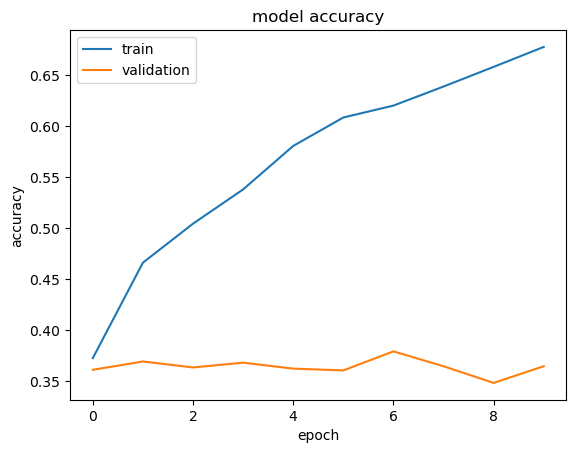

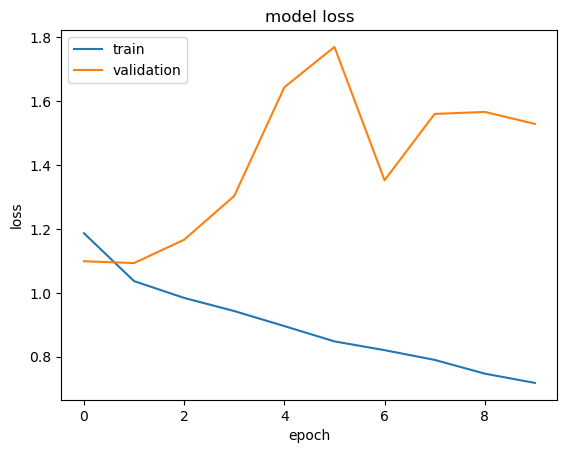

In [45]:
plot_history(history)

In [46]:
X_test

array([[   0,    0,    0, ..., 1269, 2240, 2926],
       [   0,    0,    0, ..., 2326, 4704, 2759],
       [   0,    0,    0, ..., 1382, 1531, 4837],
       ...,
       [   0,    0,    0, ..., 4070, 4186,  374],
       [   0,    0,    0, ...,    0,    0,  158],
       [   0,    0,    0, ...,  679, 2007,  129]], dtype=int32)

In [47]:
y_test

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]])

In [48]:
'''score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)'''

"score, acc = model.evaluate(X_test, y_test)\nprint('Test score:', score)\nprint('Test accuracy:', acc)"

In [49]:
# print(classification_report(y_true=np.asarray(ytest), y_pred=np.argmax(model.predict(X_test))))

In [50]:
'''cm = confusion_matrix(test, predd)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()'''

"cm = confusion_matrix(test, predd)\nplt.figure(figsize=[8, 6])\nsns.heatmap(cm, annot=True, fmt='d')\nplt.show()"